<a href="https://colab.research.google.com/github/fumo88/TVML_notebooks/blob/master/IEEE_CIS_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IEEE-CIS Fraud Detection - Kaggle Competition**
##Notebook per TVML - 11/04/2020
Link alla pagina della competition su Kaggle: https://www.kaggle.com/c/ieee-fraud-detection/overview

##**Caricamento dati e semplice visualizzazione**

In [0]:
#ogni nb inizia cosi'
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# importo pandas per la manipolazione dati
import pandas as pd

In [0]:
#cambio cartella
import os
folder_path = "/content/drive/My Drive/Progetti_Data_Science/ieee-fraud-detection/"
os.chdir(folder_path)
os.getcwd()

'/content/drive/My Drive/Progetti_Data_Science/ieee-fraud-detection'

In [0]:
#vedo cosa c'e' nella cartella cosi' controllo se ho fatto giusto
!ls -all

total 1323321
drwx------ 2 root root      4096 Apr 12 15:39 models
-rw------- 1 root root    121834 Apr 11 10:42 my_test.csv
-rw------- 1 root root   6080314 Dec 11 22:12 sample_submission.csv
-rw------- 1 root root  25797161 Dec 11 22:12 test_identity.csv
-rw------- 1 root root 613194934 Dec 11 22:12 test_transaction.csv
-rw------- 1 root root  26529680 Dec 11 22:13 train_identity.csv
-rw------- 1 root root 683351067 Dec 11 22:13 train_transaction.csv


In [0]:
#leggo tutti i file
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
#test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
#test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
#sub = pd.read_csv(f'{folder_path}sample_submission.csv')

In [0]:
#join dei dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
#test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [0]:
#print di alcune caratteristiche del nb
print(f'train_transaction dataset has {train_transaction.shape[0]} rows and {train_transaction.shape[1]} columns.')
print(f'train_identity dataset has {train_identity.shape[0]} rows and {train_identity.shape[1]} columns.')
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
#print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

train_transaction dataset has 590540 rows and 394 columns.
train_identity dataset has 144233 rows and 41 columns.
Train dataset has 590540 rows and 434 columns.


In [0]:
#stampo i primi dati di train_transaction per vedere com'e'
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#stampo i primi dati di train_identity per vedere com'e'
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [0]:
#stampo i primi dati del dataset merged per vedere com'e'
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [0]:
#scrivo un estratto del df train su file per aprirlo più agevolmente
#train[:100].to_csv("my_test.csv", sep=';', index=False) #decommento solo se voglio riscriverlo - sep per localizzazione Italia

In [0]:
#elimino quello che non serve, tengo solo il dataset principale (merged)
del train_identity, train_transaction#, test_identity, test_transaction

###**Sbilanciamento Classi**

Creo alcuni grafici utili:

In [0]:
#importo matplotlib per fare dei plot
import matplotlib.pyplot as plt

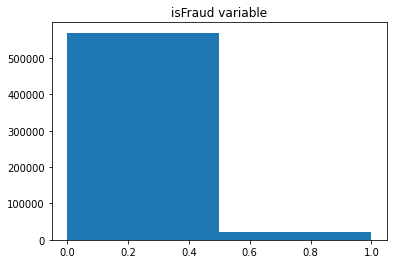

In [0]:
#voglio vedere come è distribuito il dataset in base alla variabile target isFraud
plt.hist(train['isFraud'], bins=2);
plt.title('isFraud variable');

In [0]:
#ok parecchio sbilanciata. Quanti 1 e quanti 0?
target_values_count = train['isFraud'].value_counts();
target_values_count

0    569877
1     20663
Name: isFraud, dtype: int64

In [0]:
fraud_percentage = 100 * target_values_count.iloc[1] / (target_values_count.iloc[0] + target_values_count.iloc[1]);
not_fraud_percentage = 100 * target_values_count.iloc[0] / (target_values_count.iloc[0] + target_values_count.iloc[1]);
print(f'Percentuale di record che sono frodi: {fraud_percentage:.2f} %')
print(f'Percentuale di record che NON sono frodi: {not_fraud_percentage:.2f} %')

Percentuale di record che sono frodi: 3.50 %
Percentuale di record che NON sono frodi: 96.50 %


Le classi sono troppo sbilanciate, quindi conviene trovare un modo di fare stratified sampling. Cerco su google e trovo una funzione della libreria scikit-learn.

In [0]:
#importo scikit-learn
from sklearn.model_selection import StratifiedShuffleSplit
#importo numpy
import numpy as np

In [0]:
#setto il seed random (cosi' avro' sempre gli stessi split)
np.random.seed(42)
#dichiaro l'oggetto che usero' per splittare il dataset in modo stratificato
stratifier = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8)
stratifier.get_n_splits(np.zeros(len(train)), train['isFraud'])
#print(stratifier)
split_indices = stratifier.split(X=np.zeros(len(train)), y=train['isFraud'])

In [0]:
#recupero gli indici di train e test
train_split = None
test_split = None 
for train_index, test_index in split_indices:
  train_split = train_index.copy()
  test_split = test_index.copy()
  #print("TRAIN:", len(train_index), "Type TRAIN:", type(train_index), "TEST:", len(test_index), "Type TEST:", type(test_index))

#print("TRAIN:", len(train_split), "Type TRAIN:", type(train_split), "TEST:", len(test_split), "Type TEST:", type(test_split))

In [0]:
#output di prova per vedere se e' tutto ok
print("TRAIN:", len(train_split), "Type TRAIN:", type(train_split), "TEST:", len(test_split), "Type TEST:", type(test_split))

TRAIN: 472432 Type TRAIN: <class 'numpy.ndarray'> TEST: 118108 Type TEST: <class 'numpy.ndarray'>


## **fastai Pipeline - BASELINE**

In [0]:
#elimino un paio di righe, non voglio che l'algoritmo impari qual'e' l'identificativo unico di ogni riga e overfitti
train = train.drop(columns=['TransactionID', 'TransactionDT'])
train.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [0]:
#importo fastai tabular
from fastai.tabular import *

In [0]:
#configurazione fastai
dep_var = 'isFraud'
procs = [FillMissing, Categorify, Normalize]

In [0]:
#raccolgo le label della var categoriche
cat_names = train.columns[2:11].tolist() + train.columns[13:15].tolist() + train.columns[44:53].tolist() + train.columns[403:].tolist();
#cat_names #decommenta per print

In [0]:
#raccolgo le label della var continue
cont_names = train.columns[1:2].tolist() + train.columns[11:13].tolist() + train.columns[15:44].tolist() + train.columns[53:403].tolist();
#cont_names #decommenta per print

In [0]:
#test set per fastai
test = TabularList.from_df(train.iloc[test_split].copy(), path=folder_path, cat_names=cat_names, cont_names=cont_names)

In [0]:
#training set per fastai
data = (TabularList.from_df(train, path=folder_path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(test_split))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [0]:
#visualizzo un po' di dati per vedere che sia tutto ok
data.show_batch(rows=10)

ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,dist1_na,dist2_na,D1_na,D2_na,D3_na,D4_na,D5_na,D6_na,D7_na,D8_na,D9_na,D10_na,D11_na,D12_na,D13_na,D14_na,D15_na,V1_na,V2_na,V3_na,V4_na,V5_na,V6_na,V7_na,V8_na,V9_na,V10_na,V11_na,V12_na,V13_na,V14_na,V15_na,V16_na,V17_na,V18_na,V19_na,V20_na,V21_na,V22_na,V23_na,V24_na,V25_na,V26_na,V27_na,V28_na,V29_na,V30_na,V31_na,V32_na,V33_na,V34_na,V35_na,V36_na,V37_na,V38_na,V39_na,V40_na,V41_na,V42_na,V43_na,V44_na,V45_na,V46_na,V47_na,V48_na,V49_na,V50_na,V51_na,V52_na,V53_na,V54_na,V55_na,V56_na,V57_na,V58_na,V59_na,V60_na,V61_na,V62_na,V63_na,V64_na,V65_na,V66_na,V67_na,V68_na,V69_na,V70_na,V71_na,V72_na,V73_na,V74_na,V75_na,V76_na,V77_na,V78_na,V79_na,V80_na,V81_na,V82_na,V83_na,V84_na,V85_na,V86_na,V87_na,V88_na,V89_na,V90_na,V91_na,V92_na,V93_na,V94_na,V95_na,V96_na,V97_na,V98_na,V99_na,V100_na,V101_na,V102_na,V103_na,V104_na,V105_na,V106_na,V107_na,V108_na,V109_na,V110_na,V111_na,V112_na,V113_na,V114_na,V115_na,V116_na,V117_na,V118_na,V119_na,V120_na,V121_na,V122_na,V123_na,V124_na,V125_na,V126_na,V127_na,V128_na,V129_na,V130_na,V131_na,V132_na,V133_na,V134_na,V135_na,V136_na,V137_na,V138_na,V139_na,V140_na,V141_na,V142_na,V143_na,V144_na,V145_na,V146_na,V147_na,V148_na,V149_na,V150_na,V151_na,V152_na,V153_na,V154_na,V155_na,V156_na,V157_na,V158_na,V159_na,V160_na,V161_na,V162_na,V163_na,V164_na,V165_na,V166_na,V167_na,V168_na,V169_na,V170_na,V171_na,V172_na,V173_na,V174_na,V175_na,V176_na,V177_na,V178_na,V179_na,V180_na,V181_na,V182_na,V183_na,V184_na,V185_na,V186_na,V187_na,V188_na,V189_na,V190_na,V191_na,V192_na,V193_na,V194_na,V195_na,V196_na,V197_na,V198_na,V199_na,V200_na,V201_na,V202_na,V203_na,V204_na,V205_na,V206_na,V207_na,V208_na,V209_na,V210_na,V211_na,V212_na,V213_na,V214_na,V215_na,V216_na,V217_na,V218_na,V219_na,V220_na,V221_na,V222_na,V223_na,V224_na,V225_na,V226_na,V227_na,V228_na,V229_na,V230_na,V231_na,V232_na,V233_na,V234_na,V235_na,V236_na,V237_na,V238_na,V239_na,V240_na,V241_na,V242_na,V243_na,V244_na,V245_na,V246_na,V247_na,V248_na,V249_na,V250_na,V251_na,V252_na,V253_na,V254_na,V255_na,V256_na,V257_na,V258_na,V259_na,V260_na,V261_na,V262_na,V263_na,V264_na,V265_na,V266_na,V267_na,V268_na,V269_na,V270_na,V271_na,V272_na,V273_na,V274_na,V275_na,V276_na,V277_na,V278_na,V279_na,V280_na,V281_na,V282_na,V283_na,V284_na,V285_na,V286_na,V287_na,V288_na,V289_na,V290_na,V291_na,V292_na,V293_na,V294_na,V295_na,V296_na,V297_na,V298_na,V299_na,V300_na,V301_na,V302_na,V303_na,V304_na,V305_na,V306_na,V307_na,V308_na,V309_na,V310_na,V311_na,V312_na,V313_na,V314_na,V315_na,V316_na,V317_na,V318_na,V319_na,V320_na,V321_na,V322_na,V323_na,V324_na,V325_na,V326_na,V327_na,V328_na,V329_na,V330_na,V331_na,V332_na,V333_na,V334_na,V335_na,V336_na,V337_na,V338_na,V339_na,id_01_na,id_02_na,id_03_na,id_04_na,id_05_na,id_06_na,id_07_na,id_08_na,id_09_na,id_10_na,id_11_na,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174

In [0]:
#creo il tabular_learner
learn = tabular_learner(data, layers=[200,100], metrics=accuracy, callback_fns=ShowGraph)

In [0]:
#visualizzazione modello
learn.model

In [0]:
#faccio partire il training
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time


In [0]:
learn.save('stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

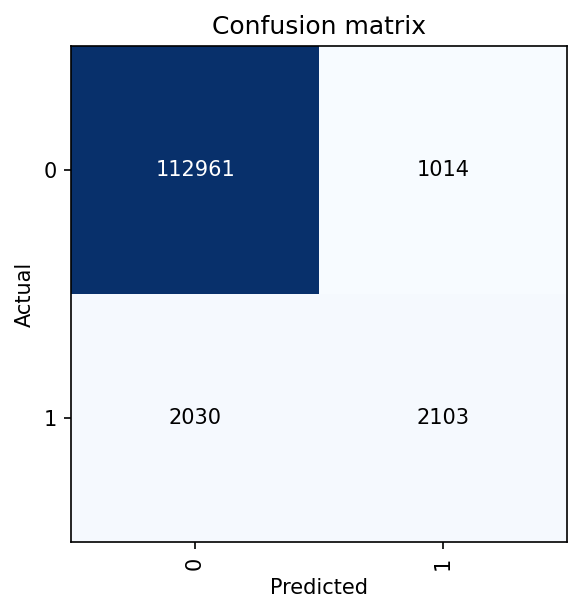

In [0]:
interp.plot_confusion_matrix(dpi=150)

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


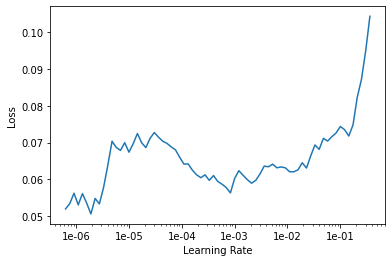

In [0]:
learn.recorder.plot()

In [0]:
#faccio partire il training
learn.fit_one_cycle(4, max_lr=2e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.056964,76.545158,0.026256,11:09
1,0.054935,71.243515,0.025570,10:52
2,0.052940,262.133453,0.025595,11:07
3,0.065102,604.668884,0.027018,11:07


In [0]:
learn.save('stage-2')

## **fastai Pipeline - BASELINE + DateTime**

In [0]:
#elimino solo la riga TransactionID, non voglio che l'algoritmo impari qual'e' l'identificativo unico di ogni riga e overfitti
# lascio il datetime perchè intanto i dati vengono mischiati (shuffled), quindi non dovrebbe essere un problema
train = train.drop(columns=['TransactionID'])
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [0]:
#importo fastai tabular
from fastai.tabular import *

In [0]:
#configurazione fastai
dep_var = 'isFraud'
procs = [FillMissing, Categorify, Normalize]

In [0]:
#raccolgo le label della var categoriche
cat_names = train.columns[3:12].tolist() + train.columns[14:16].tolist() + train.columns[45:54].tolist() + train.columns[404:].tolist();
cat_names #decommenta per print

['ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

In [0]:
#raccolgo le label della var continue
cont_names = train.columns[1:3].tolist() + train.columns[12:14].tolist() + train.columns[16:45].tolist() + train.columns[54:404].tolist();
cont_names #decommenta per print

['TransactionDT',
 'TransactionAmt',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 '

In [0]:
#test set per fastai
test = TabularList.from_df(train.iloc[test_split].copy(), path=folder_path, cat_names=cat_names, cont_names=cont_names)

In [0]:
#training set per fastai
data = (TabularList.from_df(train, path=folder_path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(test_split))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [0]:
#visualizzo un po' di dati per vedere che sia tutto ok
data.show_batch(rows=10)

ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,dist1_na,dist2_na,D1_na,D2_na,D3_na,D4_na,D5_na,D6_na,D7_na,D8_na,D9_na,D10_na,D11_na,D12_na,D13_na,D14_na,D15_na,V1_na,V2_na,V3_na,V4_na,V5_na,V6_na,V7_na,V8_na,V9_na,V10_na,V11_na,V12_na,V13_na,V14_na,V15_na,V16_na,V17_na,V18_na,V19_na,V20_na,V21_na,V22_na,V23_na,V24_na,V25_na,V26_na,V27_na,V28_na,V29_na,V30_na,V31_na,V32_na,V33_na,V34_na,V35_na,V36_na,V37_na,V38_na,V39_na,V40_na,V41_na,V42_na,V43_na,V44_na,V45_na,V46_na,V47_na,V48_na,V49_na,V50_na,V51_na,V52_na,V53_na,V54_na,V55_na,V56_na,V57_na,V58_na,V59_na,V60_na,V61_na,V62_na,V63_na,V64_na,V65_na,V66_na,V67_na,V68_na,V69_na,V70_na,V71_na,V72_na,V73_na,V74_na,V75_na,V76_na,V77_na,V78_na,V79_na,V80_na,V81_na,V82_na,V83_na,V84_na,V85_na,V86_na,V87_na,V88_na,V89_na,V90_na,V91_na,V92_na,V93_na,V94_na,V95_na,V96_na,V97_na,V98_na,V99_na,V100_na,V101_na,V102_na,V103_na,V104_na,V105_na,V106_na,V107_na,V108_na,V109_na,V110_na,V111_na,V112_na,V113_na,V114_na,V115_na,V116_na,V117_na,V118_na,V119_na,V120_na,V121_na,V122_na,V123_na,V124_na,V125_na,V126_na,V127_na,V128_na,V129_na,V130_na,V131_na,V132_na,V133_na,V134_na,V135_na,V136_na,V137_na,V138_na,V139_na,V140_na,V141_na,V142_na,V143_na,V144_na,V145_na,V146_na,V147_na,V148_na,V149_na,V150_na,V151_na,V152_na,V153_na,V154_na,V155_na,V156_na,V157_na,V158_na,V159_na,V160_na,V161_na,V162_na,V163_na,V164_na,V165_na,V166_na,V167_na,V168_na,V169_na,V170_na,V171_na,V172_na,V173_na,V174_na,V175_na,V176_na,V177_na,V178_na,V179_na,V180_na,V181_na,V182_na,V183_na,V184_na,V185_na,V186_na,V187_na,V188_na,V189_na,V190_na,V191_na,V192_na,V193_na,V194_na,V195_na,V196_na,V197_na,V198_na,V199_na,V200_na,V201_na,V202_na,V203_na,V204_na,V205_na,V206_na,V207_na,V208_na,V209_na,V210_na,V211_na,V212_na,V213_na,V214_na,V215_na,V216_na,V217_na,V218_na,V219_na,V220_na,V221_na,V222_na,V223_na,V224_na,V225_na,V226_na,V227_na,V228_na,V229_na,V230_na,V231_na,V232_na,V233_na,V234_na,V235_na,V236_na,V237_na,V238_na,V239_na,V240_na,V241_na,V242_na,V243_na,V244_na,V245_na,V246_na,V247_na,V248_na,V249_na,V250_na,V251_na,V252_na,V253_na,V254_na,V255_na,V256_na,V257_na,V258_na,V259_na,V260_na,V261_na,V262_na,V263_na,V264_na,V265_na,V266_na,V267_na,V268_na,V269_na,V270_na,V271_na,V272_na,V273_na,V274_na,V275_na,V276_na,V277_na,V278_na,V279_na,V280_na,V281_na,V282_na,V283_na,V284_na,V285_na,V286_na,V287_na,V288_na,V289_na,V290_na,V291_na,V292_na,V293_na,V294_na,V295_na,V296_na,V297_na,V298_na,V299_na,V300_na,V301_na,V302_na,V303_na,V304_na,V305_na,V306_na,V307_na,V308_na,V309_na,V310_na,V311_na,V312_na,V313_na,V314_na,V315_na,V316_na,V317_na,V318_na,V319_na,V320_na,V321_na,V322_na,V323_na,V324_na,V325_na,V326_na,V327_na,V328_na,V329_na,V330_na,V331_na,V332_na,V333_na,V334_na,V335_na,V336_na,V337_na,V338_na,V339_na,id_01_na,id_02_na,id_03_na,id_04_na,id_05_na,id_06_na,id_07_na,id_08_na,id_09_na,id_10_na,id_11_na,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,

In [0]:
#creo il tabular_learner
learn = tabular_learner(data, layers=[200,100], metrics=accuracy, callback_fns=ShowGraph)

In [0]:
#visualizzazione modello
learn.model

epoch,train_loss,valid_loss,accuracy,time
0,0.091643,0.817702,0.971043,11:22
1,0.069312,30.213902,0.971213,11:25
2,0.066917,7.521028,0.975683,11:21
3,0.065843,61.506668,0.973558,11:44


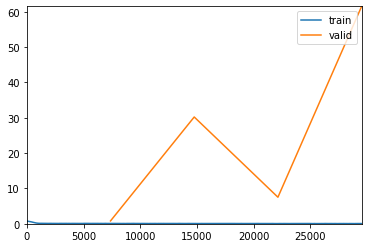

In [0]:
#faccio partire il training
learn.fit_one_cycle(4)

In [0]:
learn.save('stage-1-DT')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

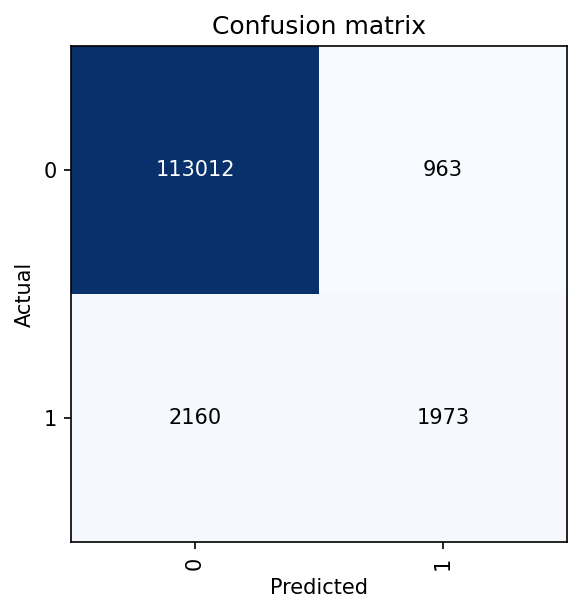

In [0]:
interp.plot_confusion_matrix(dpi=150)

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


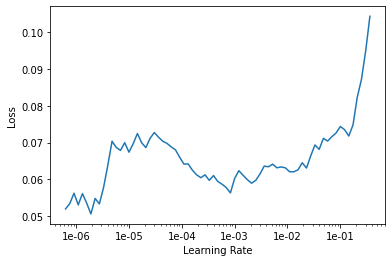

In [0]:
learn.recorder.plot()

In [0]:
#faccio partire il training
learn.fit_one_cycle(4, max_lr=2e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.056964,76.545158,0.026256,11:09
1,0.054935,71.243515,0.025570,10:52
2,0.052940,262.133453,0.025595,11:07
3,0.065102,604.668884,0.027018,11:07


In [0]:
learn.save('stage-2-DT')